# Loan Club: Machine Learning Capstone Notebook

In [1]:
# Load packages
import pandas as pd
import numpy as np
import re
from time import strptime  # format data columns
import warnings
import math

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
import seaborn as sns
import plotly.express as px

warnings.filterwarnings("ignore")  # ignore warnings throughout notebook
pd.set_option("display.max_columns", None)  # show all columns

In [2]:
# Load Data
filepath = "./data/accepted_subsampled_5percent.csv" #will be personalized
df = pd.read_csv(filepath, sep=",")

df_cleaned = df.copy() #work from second copy

In [3]:
# Features known to investors based on LC website
known_vars = ['acc_now_delinq',             # accounts now deliquent
              'collections_12_mths_ex_med', # collections excluding medical
              'fico_range_high',            # credit score range
              'fico_range_low',             # creit score range
              'delinq_2yrs',                # delinquencies in last two years
              'delinq_amnt',                # delinquency amount
              'earliest_cr_line',           # earliest credit line
              'home_ownership',             # home ownership
              'dti',                        # debt2income ratio
              'annual_inc',                 # annual income
              'initial_list_status',        # initial listing status
              'inq_last_6mths',             # credit inquires in last 6mo
              'int_rate',                   # interest rate
              'verification_status_joint',  # is this a joint app
              'emp_length',                 # length of employment (yr)
              'loan_amnt',                  # loan amount
              'id',                         # loan id
              'purpose',                    # purpose of the loan
              'term',                       # loan term (3 or 5yr)
              'addr_state',                 # borrower location state
              'installment',                # montly payment
              'mths_since_last_delinq',     # mo since last delinquency
              'mths_since_last_major_derog',# mo since last maj. derogatory
              'mths_since_last_record',     # mo since last public record
              'open_acc',                   # open credit line
              'pub_rec',                    # public records on file
              'revol_util',                 # revolving balance utilization (%)
              'revol_bal',                  # revolving credit balance ($)
              'tot_coll_amt',               # total collection amount ever
              'total_acc',                  # total credit lines
              'tot_cur_bal',                # total current balance
              'verification_status',        # verified income (Y/N I think)
              'grade'                       # loan grade
             ]

# Sanity check, print variable if not found within original dataframe
# [ print(var) for var in known_vars if (var not in df.columns)]


### Impute Missing Data of Known Variables

In [4]:
#Assess missingness of known variables
missingness = df_cleaned[known_vars].isnull().mean().T
missingness = missingness.loc[missingness>0].sort_values(ascending=False)
missingness


verification_status_joint      0.949313
mths_since_last_record         0.838543
mths_since_last_major_derog    0.744395
mths_since_last_delinq         0.513786
emp_length                     0.063868
tot_cur_bal                    0.033430
tot_coll_amt                   0.033430
revol_util                     0.001006
dti                            0.000829
collections_12_mths_ex_med     0.000476
open_acc                       0.000185
pub_rec                        0.000185
total_acc                      0.000185
inq_last_6mths                 0.000185
earliest_cr_line               0.000185
delinq_amnt                    0.000185
delinq_2yrs                    0.000185
acc_now_delinq                 0.000185
dtype: float64

In [5]:
# Drop features missing > 50% 
feat_wManyMissing = missingness.index[np.where(missingness > .5)].to_list()
df_cleaned[known_vars].drop(df_cleaned[feat_wManyMissing], axis=1, inplace=True)
[known_vars.remove(var) for var in feat_wManyMissing] #remove features from known_var list


[None, None, None, None]

In [6]:
# Replace NA's of numeric 'known_var' features with mean value
numeric_var = ['tot_cur_bal',
               'tot_coll_amt',
               'revol_util',
               'collections_12_mths_ex_med',
               'open_acc',
               'pub_rec',
               'total_acc',
               'inq_last_6mths',
               'delinq_amnt',
               'delinq_2yrs',
               'dti' ]

# List comprehension through numerica variables
[df_cleaned[var].fillna(df[var].mean(), inplace=True) for var in numeric_var]


[None, None, None, None, None, None, None, None, None, None, None]

In [7]:
# Helper function to replace missing character strings with randomly selected value
def fillna_random(var):
    #find index of missing values
    miss_idx = df_cleaned.loc[ df_cleaned[var].isnull()].index.tolist()
    
    #find new values to replace NaN values
    new_val = df_cleaned[var].loc[~df_cleaned.index.isin(miss_idx)].sample(len(miss_idx)).values.tolist()

    #replace values
    df_cleaned[var][miss_idx] = new_val

# ==================================================
# Replace NA's of character 'known_var' features with random
non_numeric_var = ['emp_length', 'earliest_cr_line', 'acc_now_delinq', 'delinq_2yrs'] #list of non-numeric variables
[fillna_random(var) for var in non_numeric_var]


[None, None, None, None]

In [8]:
#Sanity check that no more missing values
df_cleaned[known_vars].isnull().sum()


acc_now_delinq                0
collections_12_mths_ex_med    0
fico_range_high               0
fico_range_low                0
delinq_2yrs                   0
delinq_amnt                   0
earliest_cr_line              0
home_ownership                0
dti                           0
annual_inc                    0
initial_list_status           0
inq_last_6mths                0
int_rate                      0
emp_length                    0
loan_amnt                     0
id                            0
purpose                       0
term                          0
addr_state                    0
installment                   0
open_acc                      0
pub_rec                       0
revol_util                    0
revol_bal                     0
tot_coll_amt                  0
total_acc                     0
tot_cur_bal                   0
verification_status           0
grade                         0
dtype: int64

### Feature Engineering

In [10]:
# Simplify loan status (non-FullyPaid or ChargedOff loans will be converted to NAN)
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid':'Fully Paid',
                                                           'Charged Off':'Charged Off',
                                                           'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                                           'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

# Remove non-completed loans
df_cleaned.drop(df_cleaned.loc[df_cleaned['loan_status'].isnull()].index.tolist(), axis=0, inplace=True)

# Simplify home ownership
df_cleaned['home_ownership'] = df_cleaned['home_ownership'].map({'MORTGAGE':'mortgage',
                                                                 'OWN':'own',
                                                                 'RENT':'rent'})

# Remove 25 observations without houses
df_cleaned.drop(df_cleaned.loc[df_cleaned['home_ownership'].isnull()].index.tolist(), axis=0, inplace=True)


# Reformat date features and calculate features related to prepayment  
df_cleaned['term_year'] = np.where(df_cleaned['term']==' 36 months', 3,5)
df_cleaned['earliest_cr_line'] =  pd.to_datetime(df_cleaned['earliest_cr_line'])
df_cleaned['issue_date'] =  pd.to_datetime(df_cleaned['issue_d'])
df_cleaned['last_pymnt_date'] = pd.to_datetime(df_cleaned['last_pymnt_d'])
df_cleaned['exp_last_pymnt_date'] = pd.to_datetime(df_cleaned['issue_d'].str[0:3]
                                                   +'-'
                                                   + (df_cleaned['issue_d'].str[-4:].astype('int')
                                                   + df_cleaned['term_year']).astype('str'))

# Calculate credit history ( in months )
date_ofloan = df_cleaned['issue_date'].dt.to_period('M').astype(int)
date_credline = df_cleaned['earliest_cr_line'].dt.to_period('M').astype(int)
df_cleaned['credit_hist_mths'] = date_ofloan - date_credline

# Log-transform skewed continuous features
df_cleaned['delinq_amnt_log'] = df_cleaned['delinq_amnt'].add(1).apply(np.log)
df_cleaned['annual_inc_log'] = df_cleaned['annual_inc'].add(1).apply(np.log)
df_cleaned['dti_log'] = df_cleaned['dti'].add(1).apply(np.log)
df_cleaned['funded_amnt_log'] = df_cleaned['funded_amnt'].add(1).apply(np.log)
df_cleaned['tot_coll_amt_log'] = df_cleaned['tot_coll_amt'].add(1).apply(np.log)
df_cleaned['tot_cur_bal_log'] = df_cleaned['tot_cur_bal'].add(1).apply(np.log)
df_cleaned['total_acc_log'] = df_cleaned['total_acc'].add(1).apply(np.log)
df_cleaned['revol_bal_log'] = df_cleaned['revol_bal'].add(1).apply(np.log)
df_cleaned['installment_log'] = df_cleaned['installment'].add(1).apply(np.log)
df_cleaned['open_acc_log'] = df_cleaned['open_acc'].add(1).apply(np.log)

# Simplify loan purpose - debt consolidation, credit card, and other
df_cleaned['purpose'] = df_cleaned['purpose'].map({'debt_consolidation':'debt_consolidation',
                                                   'credit_card':'credit_card'})
df_cleaned['purpose'].fillna('other',inplace=True)

# Convert loan grade to ordinal feature
df_cleaned['grade'] = df_cleaned['grade'].map({'A':1,
                                               'B':2,
                                               'C':3,
                                               'D':4,
                                               'E':5,
                                               'F':6,
                                               'G':7})

# Simplify employment length to four categories
df_cleaned['emp_length'] = df_cleaned['emp_length'].map({'< 1 year':0.5,
                                                         '1 year':1,
                                                         '2 years':2,
                                                         '3 years':3,
                                                         '4 years':4,
                                                         '5 years':5,
                                                         '6 years':6,
                                                         '7 years':7,
                                                         '8 years':8,
                                                         '9 years':9,
                                                         '10+ years':10})

# Create new binary features
df_cleaned['has_pub_rec'] = np.where(df_cleaned['pub_rec']>0,1,0) #0-=no public record
df_cleaned['has_paid_early'] = np.where((df_cleaned.loan_status=='Fully Paid')&(df_cleaned.last_pymnt_date < df_cleaned.exp_last_pymnt_date), 1, 0)
df_cleaned['has_36mo_loan'] = np.where(df_cleaned['term'].str.contains('36'),1,0) #0=60mo loan
df_cleaned['has_delinq_now'] = np.where(df_cleaned['acc_now_delinq']>0, 1, 0)
df_cleaned['has_delinq_past2yrs'] = np.where(df_cleaned['delinq_2yrs']>0, 1, 0) #0=no delinq within 2yrs
df_cleaned['has_whole_liststatus'] = np.where(df_cleaned['initial_list_status']=='w', 1, 0) #0=f
df_cleaned['has_fullypaid'] = np.where(df_cleaned['loan_status']=='Fully Paid', 1, 0) #0=charged off


In [221]:
# Create response variable based on 
threshold = 10 #goal of loans is loss of <10%
df_cleaned["roi_perc"] = df_cleaned["total_pymnt"].div(df_cleaned["funded_amnt"]).sub(1).mul(100)
df_cleaned['roi_response'] = np.where(df_cleaned['roi_perc'] > threshold, 1, 0) #84% of all loans > -20% ROI

df_cleaned['roi_response_5'] = np.where(df_cleaned['roi_perc'] > 5, 1, 0)
df_cleaned['roi_response_neg_20'] = np.where(df_cleaned['roi_perc'] > -20, 1, 0)
df_cleaned['roi_response_charged_off'] = np.where(df_cleaned['loan_status'] == "Charged Off", 0, 1)

df_cleaned['credit_hist_mths'] = np.where(df_cleaned['credit_hist_mths'] < 0, 0, df_cleaned['credit_hist_mths'])

In [222]:
# Isolate list of predictor variables to be used for ML
predictor_vars = ['annual_inc_log',
                  'credit_hist_mths',
                  'delinq_amnt_log',
                  'dti_log',
                  'emp_length',
                  'fico_range_high',
                  'funded_amnt_log',
                  'grade',
                  'has_36mo_loan',
                  'has_delinq_now',
                  'has_delinq_past2yrs',
                  'has_fullypaid',
                  'has_paid_early',
                  'has_pub_rec',
                  'has_whole_liststatus',
                  'home_ownership',
                  'inq_last_6mths',
                  'installment_log',
                  'int_rate',
                  'open_acc_log',
                  'purpose',
                  'revol_bal_log',
                  'revol_util',
                  'tot_coll_amt_log',
                  'tot_cur_bal_log',
                  'total_acc_log',
                  'verification_status']

response_var = 'roi_response'
response_var_5 = 'roi_response_5'
response_var_neg_20 = 'roi_response_neg_20'
response_var_charged_off = 'roi_response_charged_off'


# Machine Learning

### Logistic Regression
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

In [13]:
# Dummify categorical features
home_ownership_dummy = pd.get_dummies(df_cleaned['home_ownership'],
                                      prefix="home_ownership",drop_first=True)

purpose_dummy = pd.get_dummies(df_cleaned['purpose'],
                               prefix="purpose",drop_first=True)

verification_status_dummy = pd.get_dummies(df_cleaned['verification_status'],
                               prefix="verification_status",drop_first=True)


In [14]:
# List of numeric features in the final dataframe
numeric_vars = ['annual_inc_log',
                'credit_hist_mths',
                'delinq_amnt_log',
                'dti_log',
                'emp_length',
                'fico_range_high',
                'funded_amnt_log',
                'grade',
                'has_36mo_loan',
                'has_delinq_now',
                'has_delinq_past2yrs',
                'has_pub_rec',
                'has_whole_liststatus',
                'inq_last_6mths',
                'installment_log',
                'int_rate',
                'open_acc_log',
                'revol_bal_log',
                'revol_util',
                'tot_coll_amt_log',
                'tot_cur_bal_log',
                'total_acc_log']

In [15]:
# final dataframe for model consumption

df_feature_final = pd.concat([df_cleaned[numeric_vars],
                      home_ownership_dummy,
                      purpose_dummy,
                      verification_status_dummy],axis=1)


In [16]:
# standardize final dataframe
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_feature_final)
df_feature_final_scaled = pd.DataFrame(scaler.transform(df_feature_final))
df_feature_final_scaled.columns = df_feature_final.columns
df_feature_final_scaled.sample(10)

,annual_inc_log,credit_hist_mths,delinq_amnt_log,dti_log,emp_length,fico_range_high,funded_amnt_log,grade,has_36mo_loan,has_delinq_now,has_delinq_past2yrs,has_pub_rec,has_whole_liststatus,inq_last_6mths,installment_log,int_rate,open_acc_log,revol_bal_log,revol_util,tot_coll_amt_log,tot_cur_bal_log,total_acc_log,home_ownership_own,home_ownership_rent,purpose_debt_consolidation,purpose_other,verification_status_Source Verified,verification_status_Verified
33775,0.003234,0.183631,-0.058612,0.871572,1.095149,2.307627,-0.212143,-1.342987,0.558221,-0.068969,-0.490903,-0.454488,-1.177565,-0.680439,-0.232232,-1.329533,0.777898,-0.634918,-1.691579,-0.487797,0.783494,0.592790,-0.348734,-0.815368,0.856201,-0.506651,-0.792002,-0.667150
41997,0.448524,-0.820966,-0.058612,0.931330,-1.524543,0.115395,1.567819,0.968740,-1.791407,-0.068969,-0.490903,-0.454488,-1.177565,-0.680439,1.360063,1.002273,0.100205,0.773695,0.579526,-0.487797,1.085135,-0.764489,-0.348734,-0.815368,0.856201,-0.506651,1.262622,-0.667150
2413,-0.459321,-0.765768,-0.058612,0.152116,1.095149,-0.510956,0.819848,0.198164,0.558221,-0.068969,-0.490903,-0.454488,-1.177565,0.341920,1.057392,0.579265,-0.577489,0.214238,1.438313,1.734238,0.496076,-0.764489,-0.348734,-0.815368,-1.167951,-0.506651,-0.792002,1.498914
86,-1.022803,-2.024275,-0.058612,-4.555191,-1.524543,-0.197780,-0.334475,1.739315,0.558221,-0.068969,-0.490903,-0.454488,-1.177565,7.498433,-0.192256,0.307782,-0.854951,-3.436411,-2.061956,1.734238,0.496076,-2.186921,-0.348734,-0.815368,-1.167951,1.973745,-0.792002,-0.667150
55480,-1.422386,-1.693089,-0.058612,-0.956221,-0.835151,-1.137308,-1.703582,0.968740,0.558221,-0.068969,-0.490903,-0.454488,0.849210,-0.680439,-1.526684,1.427386,-1.169511,-0.868114,0.542895,-0.487797,-1.832837,-2.460945,-0.348734,1.226440,-1.167951,1.973745,-0.792002,1.498914
56214,1.067893,-0.136515,-0.058612,-3.467230,-1.386665,0.741747,-1.061500,-1.342987,0.558221,-0.068969,-0.490903,-0.454488,0.849210,0.341920,-1.116306,-1.203262,-1.532645,-0.555367,-1.634598,-0.487797,-2.161968,-0.306568,2.867518,-0.815368,-1.167951,-0.506651,-0.792002,1.498914
39490,0.131922,-1.593733,-0.058612,0.158935,-1.110908,-0.824132,-1.934435,2.509891,0.558221,-0.068969,-0.490903,-0.454488,0.849210,-0.680439,-1.728897,1.848289,-1.169511,-1.623969,-0.218210,-0.487797,-1.324957,-2.186921,2.867518,-0.815368,-1.167951,1.973745,-0.792002,1.498914
28516,0.916797,0.989517,-0.058612,0.714620,1.095149,-0.510956,1.567819,-0.572411,0.558221,-0.068969,2.037061,-0.454488,0.849210,-0.680439,1.721638,-0.677132,-1.169511,0.863804,0.595806,-0.487797,-0.042978,-0.411829,-0.348734,1.226440,-1.167951,-0.506651,1.262622,-0.667150
29231,0.385371,1.265505,-0.058612,0.744325,1.095149,-0.824132,1.089738,1.739315,-1.791407,-0.068969,-0.490903,2.200280,-1.177565,1.364279,0.970655,1.780945,2.096187,0.142173,-0.869423,-0.487797,-0.218620,1.947932,2.867518,-0.815368,0.856201,-0.506651,-0.792002,1.498914
52171,-0.635318,-1.207350,-0.058612,-0.641452,-1.524543,-0.667544,-0.529175,-0.572411,0.558221,-0.068969,-0.490903,-0.454488,0.849210,0.341920,-0.477260,-0.466681,-0.104768,-0.068093,-0.368803,-0.487797,-0.824743,-1.038514,-0.348734,1.226440,0.856201,-0.506651,1.262622,-0.667150


In [226]:
# Need to reset index because feature index changed
class_response_neg_20 = df_cleaned[response_var_neg_20].reset_index().drop('index',axis=1)
class_response_charged_off = df_cleaned[response_var_charged_off].reset_index().drop('index',axis=1)

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm

### Model based on -20% threshold

In [20]:
def con_mtx(con_matrix):
    tn, fp, fn, tp = con_matrix.ravel()

    #Calculate metrics
    acc_ = (tp + tn) / (tp + tn + fn + fp) #accuracy
    err_rate = (fp + fn) / (tp + tn + fn + fp) #error rate
    sens_ = tp / (tp + fn) #sensitivity
    sp_ = tn / (tn + fp) #specificity
    pcs = tp / (tp + fp) #false positive rate 
    rcl = tp / (tp + fn)
    #Print results
    print("Accuracy  : ", acc_)
    print("Error rate  : ", err_rate)
    print("Sensitivity  : ", sens_)
    print("Specificity  : ", sp_)
    print("precision  : ", pcs)
    print("recall  : ", rcl)

In [21]:
# Quick Glance of the Data
result_neg_20 = sm.Logit(class_response_neg_20,
                         df_feature_final_scaled).fit()

print(result_neg_20.summary())

Optimization terminated successfully.
         Current function value: 0.671437
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     roi_response_neg_20   No. Observations:                67805
Model:                           Logit   Df Residuals:                    67777
Method:                            MLE   Df Model:                           27
Date:                 Tue, 24 Mar 2020   Pseudo R-squ.:                 -0.5175
Time:                         19:40:05   Log-Likelihood:                -45527.
converged:                        True   LL-Null:                       -30002.
Covariance Type:             nonrobust   LLR p-value:                     1.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
annual_inc_log                          0.0399    

In [398]:
plt.rcParams['figure.figsize'] = (10,5)
y_min, y_max = -1.5,1.5

In [400]:
table_neg_20 = pd.DataFrame(result_neg_20.summary().tables[1].data[1:])
table_neg_20.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
table_neg_20 = table_neg_20.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float, '2.5% confidence':float, '97.5% confidence':float})
slope_table_neg_20 = table_neg_20[['name', 'coef', '2.5% confidence', '97.5% confidence']].iloc[1:]

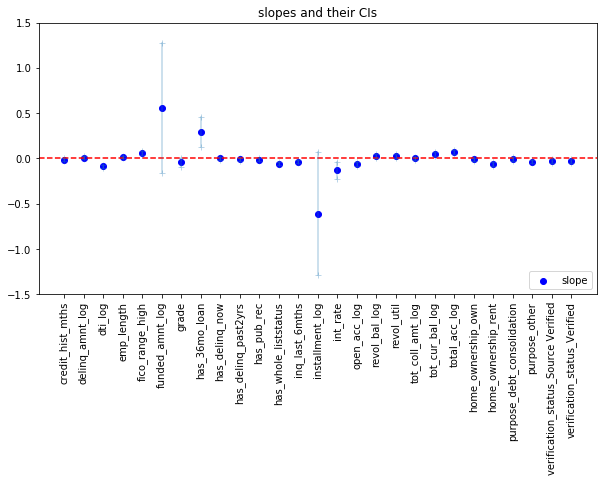

In [401]:
slope_table_neg_20['y_min'] = slope_table_neg_20['2.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
slope_table_neg_20['y_max'] = slope_table_neg_20['97.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
x = range(1,28)
plt.scatter(x, slope_table_neg_20['coef'], label='slope', c='b')
plt.axhline(0,linestyle='--', c='r')

for i in x:
    plt.axvline(i, ymin=slope_table_neg_20['y_min'][i], ymax=slope_table_neg_20['y_max'][i], marker='+', alpha=0.3)
plt.xticks(x,slope_table_neg_20.name,rotation='vertical')
plt.ylim((y_min, y_max))
plt.title('slopes and their CIs')
plt.legend(loc=4)

In [146]:
# Train logistic model using class_weight balanced and f1 score (maximizing precision)
lr_neg_20 = LogisticRegression(n_jobs=-1, 
                               solver='liblinear', 
                               class_weight="balanced", 
                               #penalty='l2'
                              )

c_param_neg_20 = {'C':np.logspace(-4,4,10),'penalty':['l1','l2']} #,
gs_lr_neg_20 = GridSearchCV(lr_neg_20, c_param_neg_20, cv=3, scoring='f1')
gs_lr_neg_20.fit(df_feature_final_scaled, class_response_neg_20)

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [147]:
# # CV results
print(gs_lr_neg_20.best_params_)

con_matrix_neg_20 = confusion_matrix(class_response_neg_20, 
                                     gs_lr_neg_20.best_estimator_.predict(df_feature_final_scaled))

print("con_mtx:")

print(con_matrix_neg_20)

con_mtx(con_matrix_neg_20)

{'C': 0.005994842503189409, 'penalty': 'l2'}
con_mtx:
[[ 7099  3865]
 [19107 37734]]
Accuracy  :  0.661204925890421
Error rate  :  0.33879507410957893
Sensitivity  :  0.6638517971182774
Specificity  :  0.6474826705581904
precision  :  0.9070891127190558
recall  :  0.6638517971182774


**Feature Selection**

In [150]:
sel_neg_20 = SelectFromModel(LogisticRegression(C=gs_lr_neg_20.best_params_["C"], 
                                                penalty= gs_lr_neg_20.best_params_["penalty"],
                                                solver='liblinear'))

sel_neg_20.fit(df_feature_final_scaled, 
               class_response_neg_20)

# 11 Features selected
selected_feat_neg_20 = df_feature_final_scaled.columns[(sel_neg_20.get_support())]
set(np.array(selected_feat_neg_20))

{'dti_log',
 'fico_range_high',
 'funded_amnt_log',
 'grade',
 'has_36mo_loan',
 'has_whole_liststatus',
 'home_ownership_rent',
 'int_rate',
 'open_acc_log',
 'tot_cur_bal_log',
 'total_acc_log'}

In [151]:
# Features dropped
set(df_feature_final_scaled.columns)-set(selected_feat_neg_20)

{'annual_inc_log',
 'credit_hist_mths',
 'delinq_amnt_log',
 'emp_length',
 'has_delinq_now',
 'has_delinq_past2yrs',
 'has_pub_rec',
 'home_ownership_own',
 'inq_last_6mths',
 'installment_log',
 'purpose_debt_consolidation',
 'purpose_other',
 'revol_bal_log',
 'revol_util',
 'tot_coll_amt_log',
 'verification_status_Source Verified',
 'verification_status_Verified'}

**Train Test Using Only 11 features  - generates similar results**

In [152]:
from sklearn.model_selection import train_test_split

In [172]:
X_train_neg_20, X_test_neg_20, y_train_neg_20, y_test_neg_20 = train_test_split(
                                                    df_feature_final_scaled[selected_feat_neg_20], 
                                                    class_response_neg_20, 
                                                    test_size=0.2)

lr_train_neg_20 = LogisticRegression(C=gs_lr_neg_20.best_params_["C"],
                                     penalty= gs_lr_neg_20.best_params_["penalty"],
                                     n_jobs=-1, 
                                     class_weight="balanced", 
                                     solver='liblinear')

lr_train_neg_20.fit(X_train_neg_20,y_train_neg_20)

LogisticRegression(C=0.005994842503189409, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
# Train Scores
con_mtx(confusion_matrix(y_train_neg_20, 
                 lr_train_neg_20.predict(X_train_neg_20)))


Accuracy  :  0.6606076248064302
Error rate  :  0.3393923751935698
Sensitivity  :  0.6644893111638955
Specificity  :  0.6404968094804011
precision  :  0.9054483337329178
recall  :  0.6644893111638955


In [174]:
# Test Scores
con_mtx(confusion_matrix(y_test_neg_20, 
                 lr_train_neg_20.predict(X_test_neg_20)))


Accuracy  :  0.6597596047489124
Error rate  :  0.3402403952510877
Sensitivity  :  0.6658753187373604
Specificity  :  0.6279707495429616
precision  :  0.9029450339811613
recall  :  0.6658753187373604


In [175]:
# All Sample Scores
con_mtx(confusion_matrix(class_response_neg_20, 
                         lr_train_neg_20.predict(df_feature_final_scaled[selected_feat_neg_20]))
)

Accuracy  :  0.6604380207949266
Error rate  :  0.33956197920507336
Sensitivity  :  0.6647666297215038
Specificity  :  0.6379970813571689
precision  :  0.9049455155071249
recall  :  0.6647666297215038


In [404]:
confusion_matrix(class_response_neg_20, 
                         lr_train_neg_20.predict(df_feature_final_scaled[selected_feat_neg_20]))

array([[ 6995,  3969],
       [19055, 37786]])

### Model predicting default/charged off

In [223]:
# Quick Glance of the Data
result_charged_off = sm.Logit(class_response_charged_off,
                         df_feature_final_scaled).fit()

print(result_charged_off.summary())

Optimization terminated successfully.
         Current function value: 0.662439
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     roi_response_charged_off   No. Observations:                67805
Model:                                Logit   Df Residuals:                    67777
Method:                                 MLE   Df Model:                           27
Date:                      Tue, 24 Mar 2020   Pseudo R-squ.:                 -0.3216
Time:                              23:56:11   Log-Likelihood:                -44917.
converged:                             True   LL-Null:                       -33987.
Covariance Type:                  nonrobust   LLR p-value:                     1.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
annual_inc

In [235]:
# Train logistic model using class_weight balanced and f1 score (maximizing precision)

lr_charged_off = LogisticRegression(n_jobs=-1, 
                               solver='liblinear', 
                               class_weight="balanced", 
                               penalty='l2'
                              )

c_param_charged_off = {'C':np.logspace(-4,4,10),'penalty':['l1','l2']} #
gs_lr_charged_off = GridSearchCV(lr_charged_off, c_param_charged_off, cv=5, scoring='f1')
gs_lr_charged_off.fit(df_feature_final_scaled, class_response_charged_off)

%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 30.3 µs


In [236]:
# CV results
print(gs_lr_charged_off.best_params_)

con_matrix_charged_off = confusion_matrix(class_response_charged_off, 
                                          gs_lr_charged_off.best_estimator_.predict(df_feature_final_scaled))

print("confusion_matrix:")

print(con_matrix_charged_off)

con_mtx(con_matrix_charged_off)

{'C': 0.005994842503189409, 'penalty': 'l2'}
confusion_matrix:
[[ 8882  4720]
 [18421 35782]]
Accuracy  :  0.6587124843300641
Error rate  :  0.34128751566993587
Sensitivity  :  0.6601479622899101
Specificity  :  0.6529922070283781
precision  :  0.8834625450595033
recall  :  0.6601479622899101


**Feature Selection**

In [252]:
sel_charged_off = SelectFromModel(LogisticRegression(C=gs_lr_charged_off.best_params_["C"], 
                                                     penalty= gs_lr_charged_off.best_params_["penalty"],
                                                     solver='liblinear'))

sel_charged_off.fit(df_feature_final_scaled, class_response_charged_off)

# 11 Features selected
selected_feat_charged_off = df_feature_final_scaled.columns[(sel_charged_off.get_support())]
set(np.array(selected_feat_charged_off))


{'annual_inc_log',
 'dti_log',
 'fico_range_high',
 'funded_amnt_log',
 'grade',
 'has_36mo_loan',
 'home_ownership_rent',
 'int_rate',
 'open_acc_log',
 'revol_bal_log',
 'tot_cur_bal_log',
 'total_acc_log'}

In [246]:
# Features dropped
set(df_feature_final_scaled.columns)-set(selected_feat_neg_20)



{'annual_inc_log',
 'credit_hist_mths',
 'delinq_amnt_log',
 'emp_length',
 'has_delinq_now',
 'has_delinq_past2yrs',
 'has_pub_rec',
 'home_ownership_own',
 'inq_last_6mths',
 'installment_log',
 'purpose_debt_consolidation',
 'purpose_other',
 'revol_bal_log',
 'revol_util',
 'tot_coll_amt_log',
 'verification_status_Source Verified',
 'verification_status_Verified'}

**Train Test Using Only 12 features  - generates similar results as GridSearchCV**

In [247]:
X_train_charged_off, X_test_charged_off, y_train_charged_off, y_test_charged_off = train_test_split(
                                                    df_feature_final_scaled[selected_feat_charged_off], 
                                                    class_response_charged_off, 
                                                    test_size=0.2)

lr_train_charged_off = LogisticRegression(C=gs_lr_charged_off.best_params_["C"],
                                          penalty= gs_lr_charged_off.best_params_["penalty"],
                                          n_jobs=-1, 
                                          class_weight="balanced", 
                                          solver='liblinear',)

lr_train_charged_off.fit(X_train_charged_off, y_train_charged_off)

LogisticRegression(C=0.005994842503189409, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [248]:
# Train Scores
con_mtx(confusion_matrix(y_train_charged_off, 
                 lr_train_charged_off.predict(X_train_charged_off)))

Accuracy  :  0.6579529533220264
Error rate  :  0.3420470466779736
Sensitivity  :  0.6612479852636426
Specificity  :  0.6447198076567413
precision  :  0.882002457002457
recall  :  0.6612479852636426


In [249]:
# Test Scores
con_mtx(confusion_matrix(y_test_charged_off, 
                         lr_train_charged_off.predict(X_test_charged_off)))


Accuracy  :  0.6587272325049776
Error rate  :  0.3412727674950225
Sensitivity  :  0.6642532256567344
Specificity  :  0.6373744619799139
precision  :  0.8762091343210481
recall  :  0.6642532256567344


In [411]:
# All Sample Scores
con_mtx(confusion_matrix(class_response_charged_off, 
                         lr_train_charged_off.predict(df_feature_final_scaled[selected_feat_charged_off]))
)

Accuracy  :  0.6581078091586167
Error rate  :  0.3418921908413834
Sensitivity  :  0.6618452853163109
Specificity  :  0.6432142332009999
precision  :  0.8808407199155351
recall  :  0.6618452853163109
